<div>
    <div style="float:left;width:50%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2021</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live: Monday, April 19 • 8:00 - 10:00 UTC</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://swung.slack.com/archives/C01T5V5S9EV">#t21-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Recording</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.youtube.com/watch?v=w3pu0H3dXe8&t=3900s">https://www.youtube.com/watch?v=w3pu0H3dXe8&t=3900s</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

# Introduction to method managers: Traveltime inversion

## Objectives:
1. Load travel time data from [third notebook](./3_Simulating_a_crosshole_traveltime_experiment)
2. Learn about method managers and how they work
3. Use the TravelTimeManager to invert the loaded data
4. Analyze inversion results and play with inversion options

In [1]:
# Just some plotting settings
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook

In [2]:
import numpy as np
import pygimli as pg
import pygimli.physics.traveltime as tt

### Load Data 

In [26]:
data = tt.load("data/traveltime.dat")
print(data)

Data: Sensors: 20 data: 100, nonzero entries: ['err', 'g', 's', 't', 'valid']


### Define function to display data

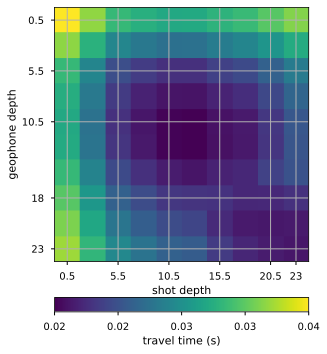

In [27]:
# For displaying data we define a function
from pygimli.viewer.mpl import showVecMatrix
def showCrossholeData(data, vals, **kwargs):
    d = -pg.y(data)  # sensor depth
    ds = d[data["s"]]  # shot depth
    dg = d[data["g"]]  # geophone depth
    ax, cb = showVecMatrix(ds, dg, vals, label="travel time (s)", **kwargs);
    ax.set_xlabel("shot depth");
    ax.set_ylabel("geophone depth");

showCrossholeData(data, data["t"])

We could add noise...

In [28]:
dt = 0.0001
data["t"] = data["t"] + np.random.randn(data.size()) * dt
data["err"] = data["err"] + dt

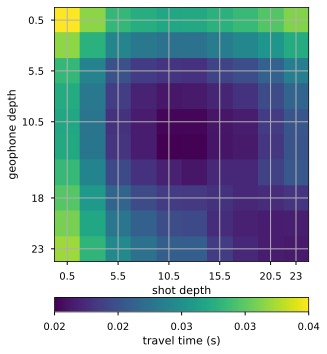

In [29]:
showCrossholeData(data, data["t"])

### Create 2D mesh

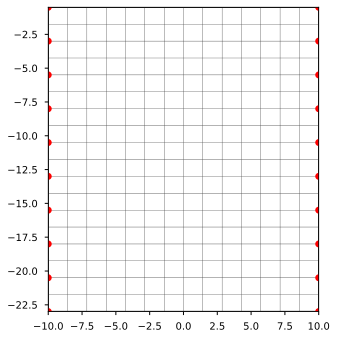

In [30]:
x = np.linspace(min(pg.x(data)), max(pg.x(data)), 15)
y = np.linspace(min(pg.y(data)), max(pg.y(data)), 19)
grid = pg.meshtools.createMesh2D(x, y)
ax, cb = pg.show(grid)
ax.plot(pg.x(data), pg.y(data), "ro");

Mesh: Nodes: 4 Cells: 0 Boundaries: 4


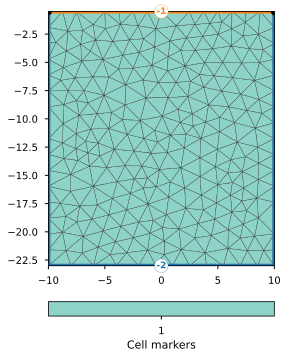

In [31]:
world = pg.meshtools.createWorld(start=[min(pg.x(data)), min(pg.y(data))],
                       end=[max(pg.x(data)), max(pg.y(data))])
print(world)

from pygimli.viewer import showMesh
mesh = pg.meshtools.createMesh(world, 
                     area=1.5,
                     quality=30,
                     smooth=[2, 4] # [0:no smoothing or 1:node center or 2:weighted node center, # of iter]
                    )
showMesh(mesh, markers=True, showMesh=True); 

### Inversion

We create an instance of the [`TravelTimeManager`](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.traveltime.html?highlight=traveltimemanager#pygimli.physics.traveltime.TravelTimeManager) class with the loaded data. Method Managers work as an interface for end-user interaction and can be seen as simple but complete application classes which manage all tasks of geophysical data processing. In this example we are using the TravelTimeManager from the TravelTime physics module where we use the `invert` method. 

In [32]:
mgr = tt.TravelTimeManager(data)

20/03/24 - 14:37:00 - pyGIMLi - INFO - Found 1 regions.
20/03/24 - 14:37:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/03/24 - 14:37:00 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
20/03/24 - 14:37:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000001C237530950>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C237530A90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001C2375309F0>
min/max (data): 0.02/0.04
min/max (error): 0.39%/0.68%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  840.67
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   32.79 (dPhi = 95.49%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.43 (dPhi = 74.34%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.72 (dPhi = 50.30%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.98 (dPhi = 18.45

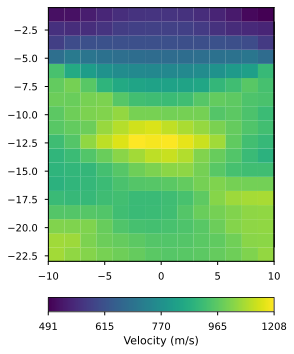

In [35]:
data.remove(data["t"] <= 0)

mgr.invert(data, mesh=grid, 
           startModel=0.001,
           useGradient=False,
           #zWeight=1,
           secNodes=3,
           lam=125,
           verbose=True)
mgr.showResult();

20/03/24 - 14:38:14 - pyGIMLi - INFO - Found 1 regions.
20/03/24 - 14:38:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/03/24 - 14:38:14 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
20/03/24 - 14:38:14 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000001C237530950>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C237530A90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001C2375309F0>
min/max (data): 0.02/0.04
min/max (error): 0.39%/0.68%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  830.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   29.21 (dPhi = 96.14%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.85 (dPhi = 76.82%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.42 (dPhi = 49.07%) lam: 125.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.50 (dPhi = 25.37

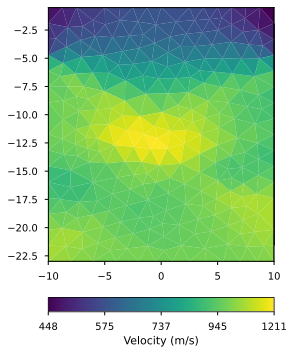

In [36]:
mgr.invert(data, mesh=mesh, 
           startModel=0.001,
           useGradient=False,
           #zWeight=1,
           secNodes=3,
           lam=125,
           verbose=True)
mgr.showResult();

The Method Manager also has `showResult()` and `drawRayPaths()` methods.

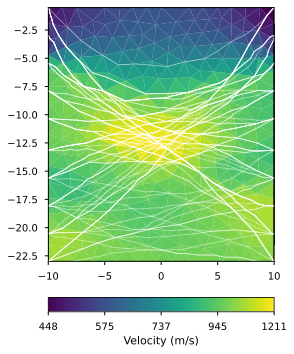

In [37]:
ax, cb = mgr.showResult();
mgr.drawRayPaths(ax);

Now we look at the simulated data (left) and inverted response (right)

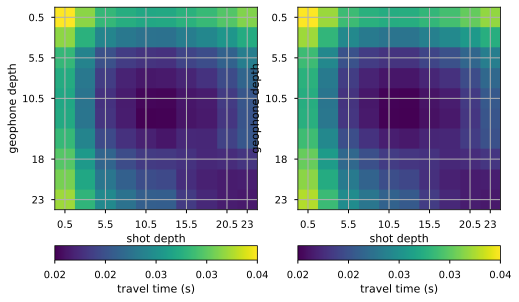

In [38]:
fig, ax = plt.subplots(ncols=2)
showCrossholeData(data, data["t"], ax=ax[0])
showCrossholeData(data, mgr.inv.response, ax=ax[1])

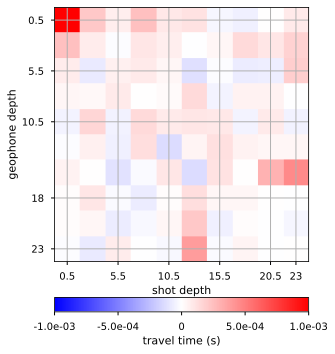

In [39]:
# Have a look at the misfit
misfit = data["t"] - mgr.inv.response
showCrossholeData(data, misfit, cMap="bwr", cMin=-0.001, cMax=0.001)